# 多层感知机的从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1:             
        y_hat = y_hat.argmax(axis = 1)   # 找下标最大的那个把坐标返回
    cmp = y_hat.type(y.dtype) == y       # 等号表达式从右向左
    return float(cmp.type(y.dtype).sum())  

In [3]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 训练损失总和，训练准确度总和，样本数
    metric = d2l.Accumulator(3)
    for X,y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)              
        l = loss(y_hat,y)           
        if isinstance(updater,torch.optim.Optimizer):
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())            # .numel()返回数组元素个数
    # 返回训练损失和训练精度
    return metric[0]/metric[2],metric[1]/metric[2]

In [4]:
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

In [10]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = d2l.Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3,0.9],
                        legend = ['train loss', 'train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = d2l.evaluate_accuracy(net,test_iter)
        animator.add(epoch + 1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics
    print(train_loss)
    assert train_loss < 0.5, train_loss
    assert train_acc<=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc

In [6]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

`class torch.nn.Parameter()`
Variable的一种，常被用于模块参数(module parameter)。

Parameters 是 Variable 的子类。Paramenters和Modules一起使用的时候会有一些特殊的属性，即：当Paramenters赋值给Module的属性的时候，他会自动的被加到 Module的 参数列表中(即：会出现在 parameters() 迭代器中)。将Varibale赋值给Module属性则不会有这样的影响。 这样做的原因是：我们有时候会需要缓存一些临时的状态(state), 比如：模型中RNN的最后一个隐状态。如果没有Parameter这个类的话，那么这些临时变量也会注册成为模型变量。

Variable 与 Parameter的另一个不同之处在于，Parameter不能被 volatile(即：无法设置volatile=True)而且默认requires_grad=True。Variable默认requires_grad=False

In [7]:
# 初始化模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens,num_outputs,requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1, b1, W2, b2]

In [8]:
# 激活函数
def relu(X):
    a = torch.zeros_like(X)       # 生成一个shape和X一样的全零数组
    return torch.max(X, a) 

# 模型
def net(X):
    X = X.reshape((-1,num_inputs))      # [batch_size,num_inputs]
    H = relu(X@W1 + b1)                 # @为矩阵相乘
    return (H@W2 + b2)

# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')  # reduction：用来指定损失结果返回的是mean、sum还是none。  默认为平均值  分类交叉熵

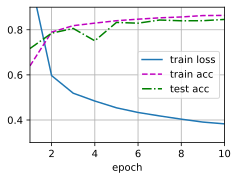

In [9]:
num_epochs ,lr = 10, 0.1
updater = torch.optim.SGD(params, lr = lr)
train_ch3(net,train_iter,test_iter, loss, num_epochs, updater)

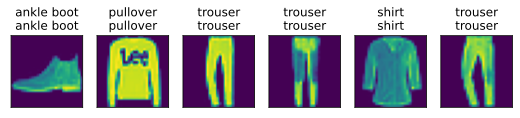

In [11]:
d2l.predict_ch3(net,test_iter)

# 多层感知机的简洁实现

In [12]:
import torch 
from torch import nn
from d2l import torch as d2l

In [13]:
# 定义网络
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

# 参数标准化 线性函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

0.3797237126668294


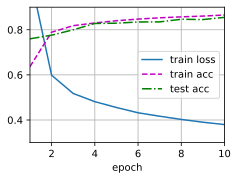

In [14]:
# 训练
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 多项式回归

In [15]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

$t = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6\frac{x^3}{3!}$

In [16]:
max_degress = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degress) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2 , -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)                        # 特征随机打乱
poly_features = np.power(features, np.arange(max_degress).reshape(1,-1))        # np.power(a,b)  即是a^b       poly_features.shape为(200,20)

for i in range(max_degress):
    poly_features[:,i] /= math.gamma(i + 1) # gamma(n) = (n-1)!          0！ = 1 

# poly_features为 x从0到19次方 labels除了前四个系数其他为0

# labels的维度为：（n_train+n_test,）
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [17]:
# Numpy ndarray转化为tensor      网络的输入数据类型为float32
true_w,features,poly_features,labels = [torch.tensor(x, dtype=  
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [18]:
# 对模型进行训练和测试
# 在测试集上通过迭代器进行评估
def evaluate_loss(net,data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和，样本数量
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

In [19]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')          # L2范数
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为在多项式已经实现了
    net = nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss', yscale='log',
                            xlim =[1,num_epochs],ylim=[1e-3,1e2],
                            legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)       # 更新网络参数 
        if epoch == 0 or (epoch+1)%20 == 0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),      # 训练数据集全部输入进去，在evaluate_loss内部实现的时候还是epoch
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

weight: [[ 5.0028257  1.2120713 -3.4042473  5.6219354]]


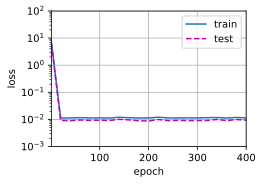

In [20]:
# 三阶多项式函数拟合
# 从多项式特征中选择前四个维度，即为1,x,x^2/2!,x^3/3!
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
      labels[:n_train], labels[n_train:])

weight: [[3.7199962 4.2418227]]


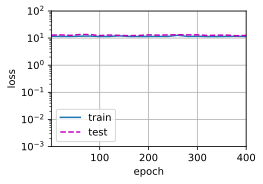

In [21]:
# 线性函数拟合(欠拟合)
# 从多项式特征选择前两个维度，为1和x
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9669156   1.3906634  -3.128392    4.875739   -1.0917814   0.84955037
  -0.1353097   0.20084411 -0.16302364 -0.1524941  -0.16138081 -0.17884736
  -0.21682537 -0.14089613 -0.20825692 -0.04946152  0.00726443  0.03028697
  -0.04078263  0.12695757]]


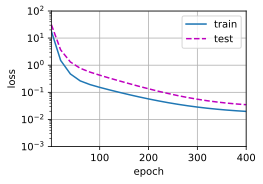

In [27]:
# 高阶多项式拟合（过拟合）
# 从特征多项式选取所有维度
train(poly_features[:n_train,:],poly_features[n_train:,:],
      labels[:n_train], labels[n_train:])

# 权重衰减

In [22]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
n_train, n_test, num_inputs, batch_size=20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [24]:
# 初始化模型参数
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

$L(w,b)+\frac{\lambda}{2}||w||$

In [25]:
# 定义训练代码实现
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w,b),d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项。
            # 广播机制l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X),y) + lambd * l2_penalty(w)               # 权重衰减直接在后面加
            l.sum().backward()
            d2l.sgd([w,b],lr, batch_size)
        if (epoch + 1)%5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter, loss),
                                  d2l.evaluate_loss(net,test_iter, loss)))
    print('w的L2范数是：',torch.norm(w).item())

w的L2范数是： 13.435979843139648


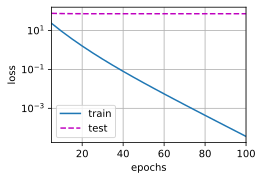

In [33]:
train(lambd = 0)

w的L2范数是： 0.3587993383407593


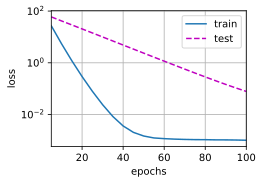

In [38]:
train(lambd = 3)

# 权重衰减简洁实现

```python
class torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```
实现随机梯度下降算法（momentum可选）。



参数：

params (iterable) – 待优化参数的iterable或者是定义了参数组的dict

lr (float) – 学习率

momentum (float, 可选) – 动量因子（默认：0）

weight_decay (float, 可选) – 权重衰减（L2惩罚）（默认：0）

dampening (float, 可选) – 动量的抑制因子（默认：0）

nesterov (bool, 可选) – 使用Nesterov动量（默认：False）

In [26]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs ,lr= 100,0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay':wd},
        {"params":net[0].bias}],lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1)%5 == 0:
            animator.add(epoch+1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：',net[0].weight.norm().item())

w的L2范数： 14.784260749816895


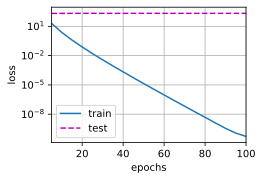

In [27]:
train_concise(0)

w的L2范数： 0.3395850658416748


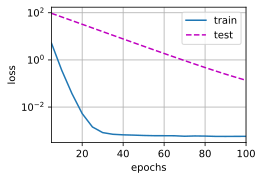

In [45]:
train_concise(3)

# 从零开始实现Dropout

In [28]:
import torch
from torch import nn
from d2l import torch as d2l

$h^{'} = \begin{cases} 0, & \text{概率为$p$} \\ \frac{h}{1-p}, &\text{其他情况} \end {cases}$

In [29]:
def dropout_layer(X, dropout):
    assert 0<= dropout <=1
    # 在本种情况下，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本种情况下，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()   # torch.rand(X.shape) > dropout 是个判断句，其中dropout 为False， 1- dropout 为 True, .float()转换后为1.和0.
    return mask * X/(1.0 - dropout)                   # 整体期望不变

In [30]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

# 定义模型
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,
                 is_training = True):
        super(Net,self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens,num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self,X):
        H1 = self.relu(self.lin1(X.reshape(-1,self.num_inputs)))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

0.33020125430425007


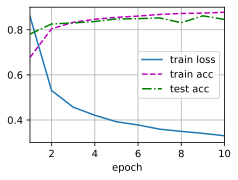

In [31]:
num_epochs ,lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr = lr)
train_ch3(net,train_iter,test_iter, loss, num_epochs, trainer)

# Dropout简洁实现

In [36]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784,256),
        nn.ReLU(),
        # 在第一个全连接层后面添加一个dropout层
        nn.Dropout(dropout1),            # Dropout 的一个参数为p的大小
        nn.Linear(256,256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.1)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

0.35986329046885174


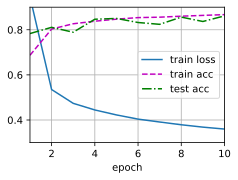

In [37]:
trainer = torch.optim.SGD(net.parameters(),lr = lr)
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)